This notebook contains functions used to analyse the results of the MCMC algorithm. We start by opening the .pkl file in which the results were saved, and load the "experiemt" dictionary with all relevant fields.

In [104]:
# Some necessary module imports
import pickle
from icesheet_functions import *
import matplotlib
import matplotlib.pyplot as plt
import random

## Loading the data

In [105]:
# Here we specify the parameters of the experiments we want to analyse, to load the correct file

problem = 'Laplace' # 'Stokes' or 'Laplace'
reg_type = 'squared_exp' # type of prior used, 'matern' or 'squared_exp'
N = 1000 # Number of observations
gamma = 1e-7 #(initial) step size
scale_noise = 0.1

method = 'adaptive' # 'LDA' if multilevel MC only was used, 'adaptive' if adaptive step size approach was used,
                        # 'combined' if the approach combining multivel Monte-Carlo and adaptive step size was used
                        # 'PCN' if regular pCN was used

filename = f"experiment_{method}_{problem}_{reg_type}_{N}_{gamma}_{scale_noise}.pkl"

with open(filename, 'rb') as f:
    experiment = pickle.load(f)
    
    
# Retrieve the relevant quantities of the experimnent
theta_0 = experiment['theta_0'] # ground truth
observations = experiment['observations'] # noisy/real-life observations
covariates = experiment['covariates'] # covariates, coordinates where the observations were performed

if method=='LDA':
    size_msh_fine = experiment['size_mesh_fine']
    chain = experiment['fine_chain']
    likelihoods = experiment['fine_likelihood']
    accept_reject = experiment['fine_acceptance']
    accept_reject_coarse = experiment['coarse_acceptance']
    
elif method=='adaptive':
    size_msh_fine = experiment['size_mesh']
    chain = experiment['chain']
    likelihoods = experiment['likelihood']
    accept_reject = experiment['acceptance']
    list_gammas = experiment['gammas']

elif method=='combined':
    size_msh_fine = experiment['size_mesh_fine']
    chain = experiment['fine_chain']
    likelihoods = experiment['fine_likelihood']
    accept_reject = experiment['fine_acceptance']
    accept_reject_coarse = experiment['coarse_acceptance']
    list_gammas = experiment['gammas']
    
else:
    size_msh_fine = experiment['size_mesh']
    chain = experiment['chain']
    likelihoods = experiment['likelihood']
    accept_reject = experiment['acceptance']

n_iter = len(chain)

### Visualise the noisy observations

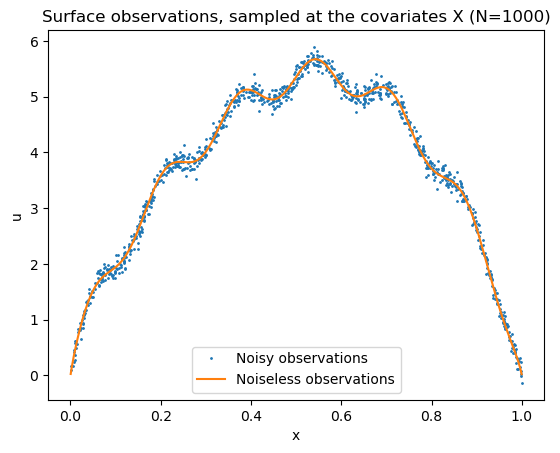

In [106]:
scale_noise = 0.1
size_msh_fine = 80

#-----------------------------------DATA GENERATION----------------------------------------------------------

# Generate K coefficients following prior assumptions
theta_0 = np.array([-0.6,  0.7,  2,  0.1, -0.08]) # ground truth
beta_0 = build_beta(theta_0) # corresponding true basal drag
interval = [(x,0) for x in np.linspace(0,1,100)]


# Retrieve the covariates (points at the surface where measurements were realised) and noisy observations
covariates = experiment['covariates']
observations = experiment['observations']

# Retrieve the true values according to the model with true coefficients
noiseless_observations = forward_map(problem, theta_0, size_msh=size_msh_fine, covariates=covariates) # retrieve the true solution for comparison

# Plot
plt.plot(covariates, observations, 'o ', label='Noisy observations', markersize = 1)
plt.plot(covariates, noiseless_observations, label='Noiseless observations')
plt.title(f"Surface observations, sampled at the covariates X (N={N})")
plt.xlabel('x')
plt.ylabel('u')
plt.legend(loc='lower center')

#plt.savefig(f'observations_N{N}_{problem}.eps', format='eps')
plt.show()

## MCMC Analysis

### Accept/reject ratio

Average acceptance probability:  0.3754532490935018


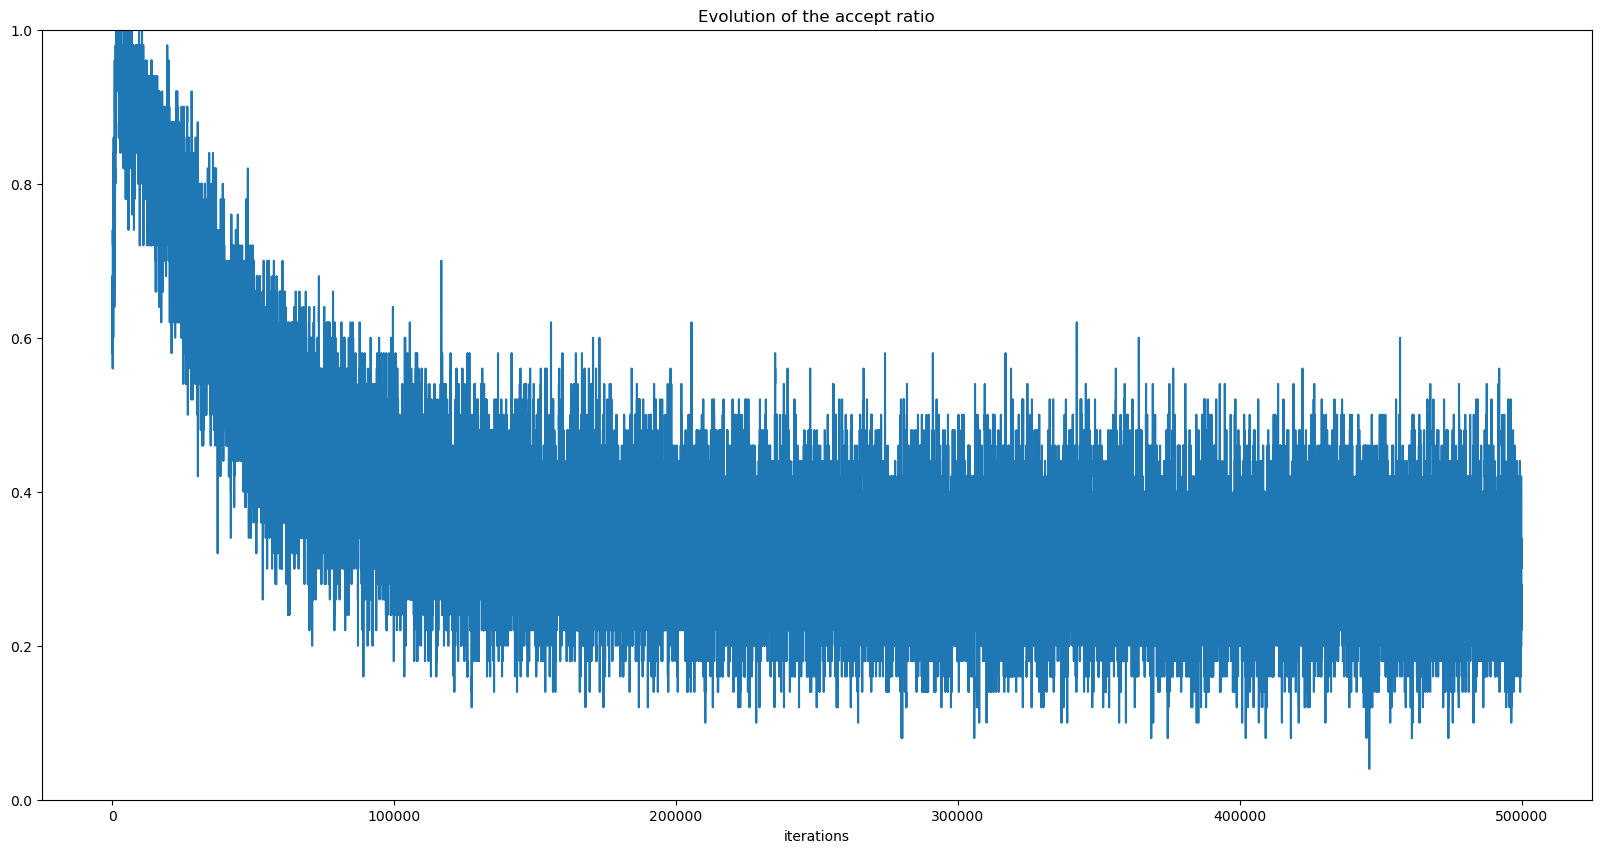

In [107]:
### ACCEPTANCE PROBABILITY

# Analysis of the acceptance probability:
print("Average acceptance probability: ", sum(accept_reject)/len(accept_reject))

# Plot moving average of the acceptance probability (should stabilise as iteration increase)

def moving_average(l, width=50):
    """
    Compute the moving average of list l
    
    Keyword arguments:
    l -- float list, list of which we want to compute the moving average
    width -- int, window size of the moving average
    
    Returns:
    list of moving averages
    """
    return np.convolve(l, np.ones(width), 'valid') / width


movingAverage = moving_average([int(e) for e in accept_reject])

plt.figure(figsize=(20,10))
plt.ylim(0,1)
plt.plot(movingAverage)
plt.title("Evolution of the accept ratio")
plt.xlabel('iterations')
plt.show()

### Likelihood

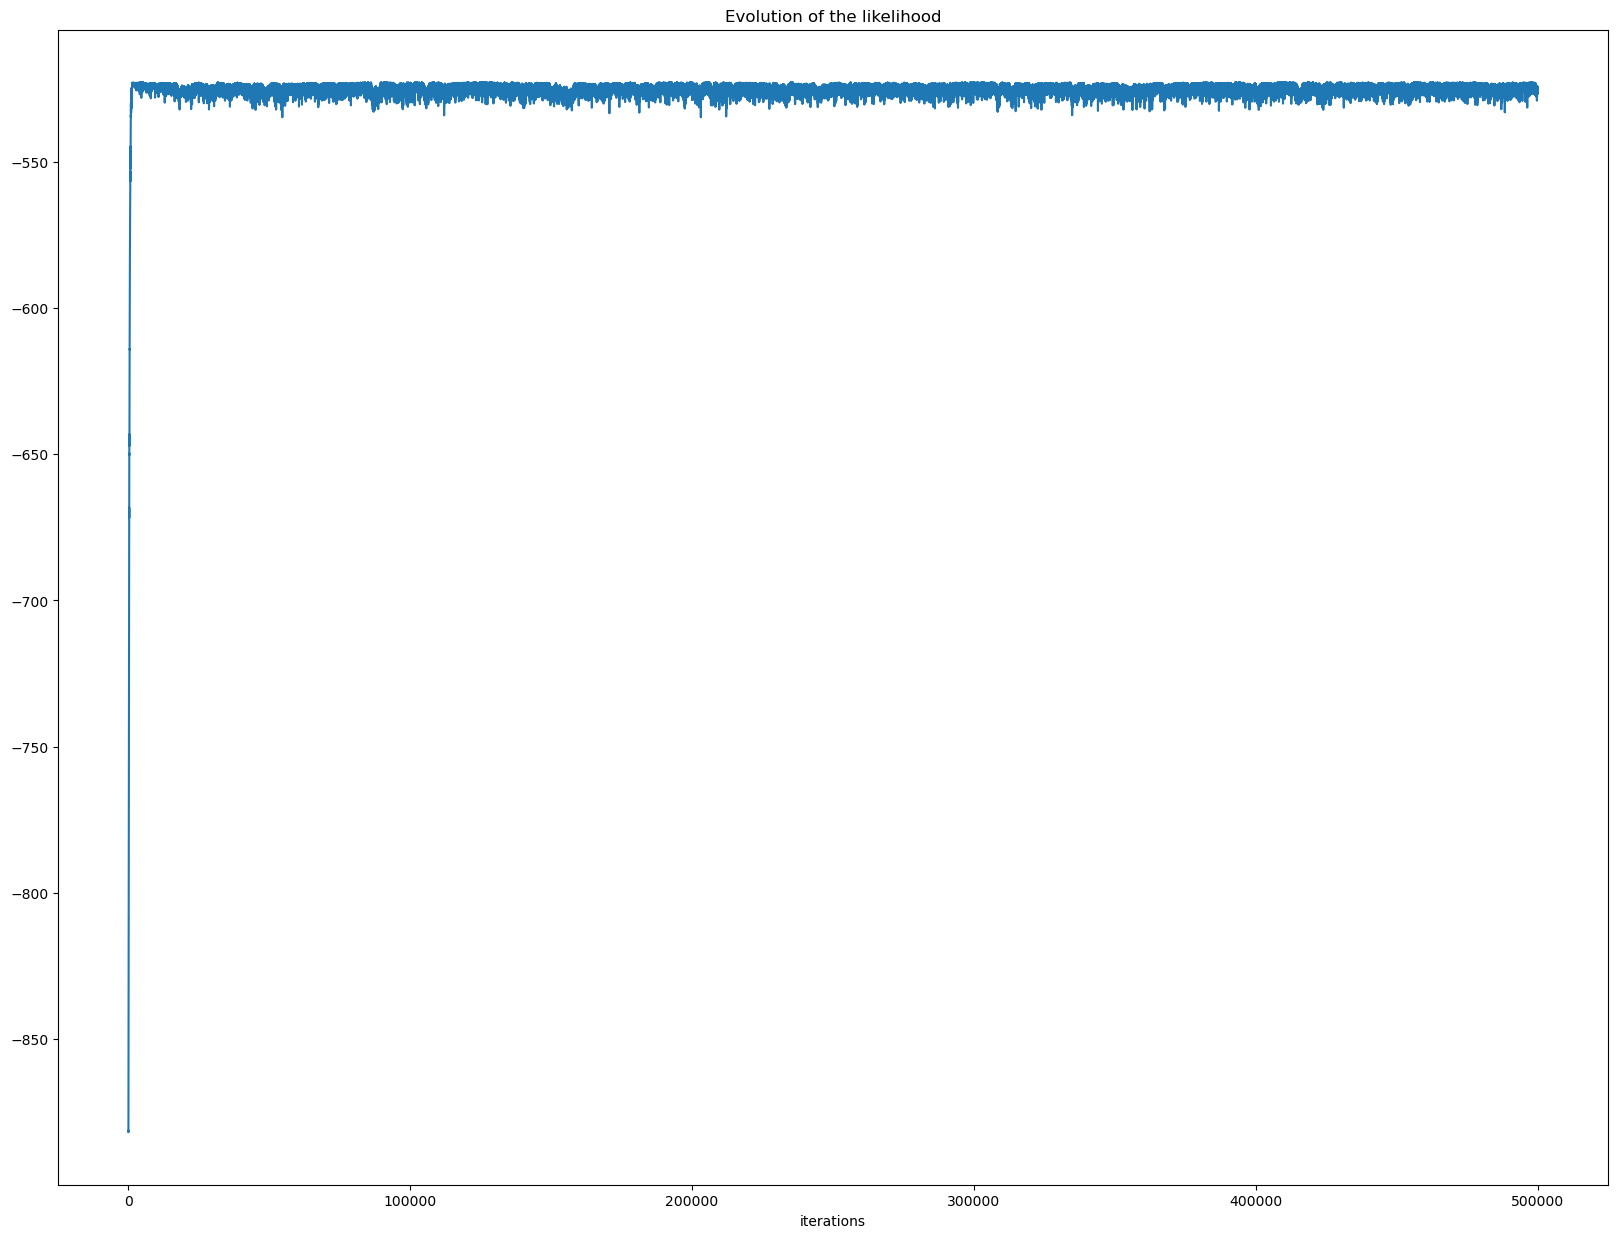

In [108]:
# Plot the evolution of the likelihood
plt.figure(figsize=(20,15))
plt.plot(likelihoods)
plt.title("Evolution of the likelihood")
plt.xlabel('iterations')
plt.show()

### Chain values

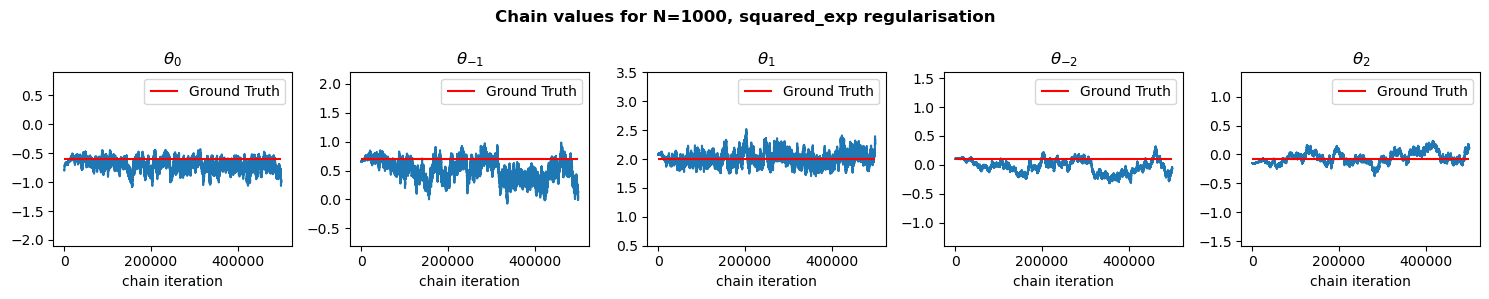

In [109]:
### CHAIN VALUES

# Plot the chain so we can visually assess if converges

delta = 1.5 # margin around ground truth in display
fig = plt.figure(figsize=(15,3))

plt.subplot(1, 5, 1)
plt.title(r'$\theta_0$')
plt.xlabel('chain iteration')
plt.plot([theta[0] for theta in chain])
plt.hlines(theta_0[0],0,n_iter,'r',label='Ground Truth')
plt.ylim(-delta+theta_0[0],delta+theta_0[0])
plt.legend(frameon=True)

plt.subplot(152)
plt.title(r'$\theta_{-1}$')
plt.plot([theta[1] for theta in chain])
plt.xlabel('chain iteration')
plt.hlines(theta_0[1],0,n_iter,'r',label='Ground Truth')
plt.ylim(-delta+theta_0[1],delta+theta_0[1])
plt.legend(frameon=True)

plt.subplot(153)
plt.title(r'$\theta_1$')
plt.plot([theta[2] for theta in chain])
plt.xlabel('chain iteration')
plt.hlines(theta_0[2],0,n_iter,'r',label='Ground Truth')
plt.ylim(-delta+theta_0[2],delta+theta_0[2])
plt.legend(frameon=True)

plt.subplot(154)
plt.title(r'$\theta_{-2}$')
plt.plot([theta[3] for theta in chain])
plt.xlabel('chain iteration')
plt.hlines(theta_0[3],0,n_iter,'r',label='Ground Truth')
plt.ylim(-delta+theta_0[3],delta+theta_0[3])
plt.legend(frameon=True)

plt.subplot(155)
plt.title(r'$\theta_2$')
plt.plot([theta[4] for theta in chain])
plt.xlabel('chain iteration')
plt.hlines(theta_0[4],0,n_iter,'r',label='Ground Truth')
plt.ylim(-delta+theta_0[4],delta+theta_0[4])
plt.legend(frameon=True)

plt.suptitle(f'Chain values for N={N}, {reg_type} regularisation', fontweight='bold')
fig.tight_layout()
plt.show()

### Posterior samples and basal drag reconstruction

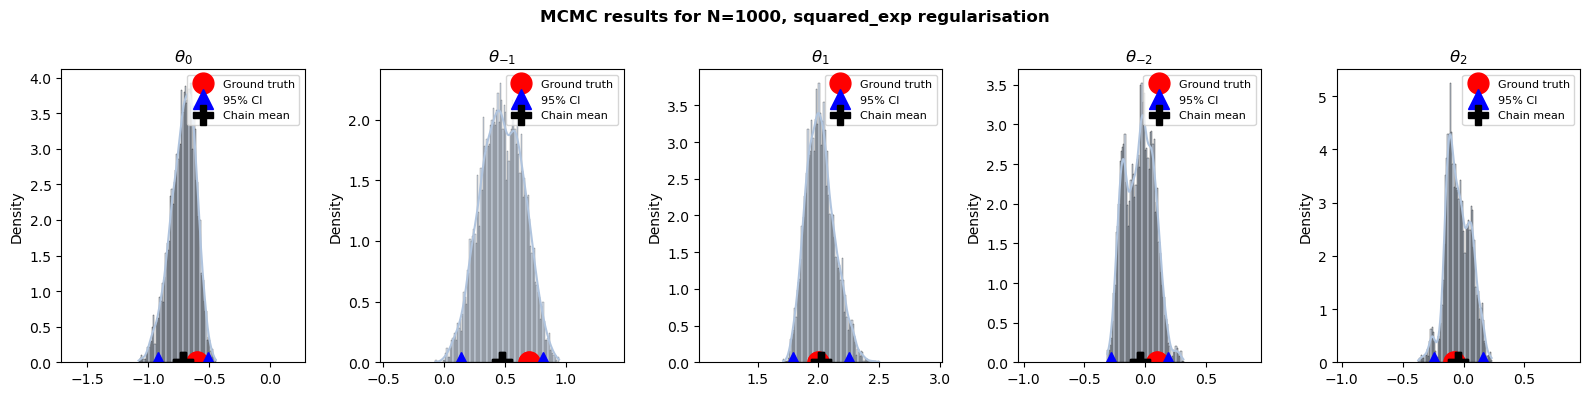

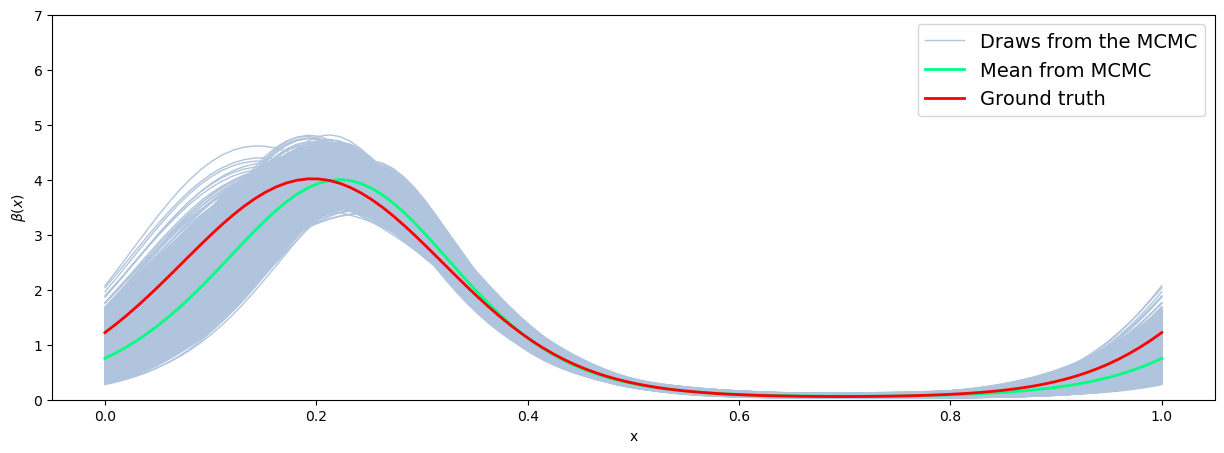

In [110]:
# CREATE POSTERIOR SAMPLES AND BASAL DRAG RECONSTRUCTION

#  Plot histogram of chain, with mean + 95% confidence interval
import seaborn as sns
import scipy.stats as st

burnin = 100000
n_draws = 5000 # for thinning, number of samples we want to extract from the chains
indexes = list(np.linspace(burnin, n_iter-1, n_draws, dtype=int))

# Thin the chains
chain_thinned =[chain[i] for i in indexes]

# Compute statistics
confidence_intervals=[]
means = []

for k in range(K):
    
    # Define sample data
    data = [theta[k] for theta in chain_thinned]
    means.append(np.mean(data))
  
    # Create 95% confidence interval
    confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
    confidence_intervals.append(confidence_interval)



    
#-------------------------------------------Plot histograms----------------------------------------
fig = plt.figure(figsize=(16,4))
plt.suptitle(f'MCMC results for N={N}, {reg_type} regularisation', fontweight='bold')

delta = 1 # range around histograms
binrange = [(np.mean([theta[k] for theta in chain][burnin:])-delta, np.mean([theta[k] for theta in chain][burnin:])+delta) for k in range(K)]
binwidth = 1e-2

plt.subplot(1, 5, 1)
plt.title(r'$\theta_0$')
sns.histplot([theta[0] for theta in chain_thinned], kde = True, bins = 30, stat='density', binwidth = binwidth, color="lightsteelblue")
plt.plot([theta_0[0], theta_0[0]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[0][0], confidence_intervals[0][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[0], means[0]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.xlim(binrange[0][0], binrange[0][1])
plt.legend(loc = 'upper right', fontsize=8)

plt.subplot(1,5, 2)
plt.title(r'$\theta_{-1}$')
sns.histplot([theta[1] for theta in chain_thinned], kde = True, bins = 30, stat='density', binwidth = binwidth, color="lightsteelblue")
plt.plot([theta_0[1], theta_0[1]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[1][0], confidence_intervals[1][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[1], means[1]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.xlim(binrange[1][0], binrange[1][1])
plt.legend(loc = 'upper right', fontsize=8)


plt.subplot(1,5, 3)
plt.title(r'$\theta_1$')
sns.histplot([theta[2] for theta in chain_thinned], kde = True, bins = 30, stat='density', binwidth = binwidth, color="lightsteelblue")
plt.plot([theta_0[2], theta_0[2]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[2][0], confidence_intervals[2][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[2], means[2]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.xlim(binrange[2][0], binrange[2][1])
plt.legend(loc = 'upper right', fontsize=8)


plt.subplot(1,5, 4)
plt.title(r'$\theta_{-2}$')
sns.histplot([theta[3] for theta in chain_thinned], kde = True, bins = 30, stat='density', binwidth = binwidth, color="lightsteelblue")
plt.plot([theta_0[3], theta_0[3]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[3][0], confidence_intervals[3][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[3], means[3]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.xlim(binrange[3][0], binrange[3][1])
plt.legend(loc = 'upper right', fontsize=8)

plt.subplot(1,5, 5)
plt.title(r'$\theta_2$')
sns.histplot([theta[4] for theta in chain_thinned], kde = True, bins = 30, stat='density', binwidth = binwidth, color="lightsteelblue")
plt.plot([theta_0[4], theta_0[4]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[4][0], confidence_intervals[4][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[4], means[4]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.xlim(binrange[4][0], binrange[4][1])
plt.legend(loc = 'upper right', fontsize=8)


fig.tight_layout()
plt.show()


#-----------------ADD THE BETA reconstruction from samples drawn from the chain---------------------------------

plt.figure(figsize=(15,5))
interval = [(x,0) for x in np.linspace(0,1,100)]


drawn = 0

for i in indexes: 

    draw = chain[i]
    
    beta = build_beta(draw)
    beta_values = [beta(x) for x in interval]

    if drawn ==0:
        plt.plot([x[0] for x in interval], beta_values, linewidth = 1, color='lightsteelblue', label = 'Draws from the MCMC') # add a legend for the first plot

    else:
        plt.plot([x[0] for x in interval], beta_values, linewidth = 1, color='lightsteelblue')
   
    drawn+=1 # update the count
        
        
#------------------------------True function-------------------------------------------------

# Build the true function
beta_0 = build_beta(theta_0)

# Add the reconstruction from the posterior mean to the plots
beta = build_beta(means)
beta_values = [beta(x) for x in interval]
plt.plot([x[0] for x in interval], beta_values, color='springgreen',linewidth=2, label = "Mean from MCMC")


#plt.title(f"Reconstruction of the basal drag for N={N} and {reg_type} regularisation")
plt.plot([x[0] for x in interval], [beta_0(x) for x in interval],linewidth=2, label = "Ground truth", color='r')


plt.legend(frameon=True, fontsize=14)

plt.xlabel('x')
plt.ylabel(r'$\beta(x)$')
plt.ylim(0,7)
fig.tight_layout()
plt.show()